# <center>  Titanic, ML from Disaster </center>

 **Brull Borràs, Pere Miquel, 27/01/2018. **

- ** 1 Introduction**
- ** 2 Exploratory Analysis**
    - Data visualization
    - Oulier detection
    - Working with missing values
- **3 Feature Engineering**
    - Hidden information
    - Combining variables
- **4 Modelling**
    - Hyperparameter tuning

# Introduction

The purpose of this Notebook is to give an end-to-end workflow example when aiming to solve a Machine Learning problem. The data used is taken from [Kaggle](https://www.kaggle.com/c/titanic/data). 

It is vital to always understand the different variables that are given to us, and even more when working with small dimentions like in this case, where we will try to extract *hidden* information and take advantage of this knowledge to extract more powerful features than the raw ones.  

### Data Dictionary

| Variable  | Definition  | 
|---|---|
| survival  | Survival {0,1}  |   
|pclass   | Ticket class {1,2,3}  |  
| sex  | Sex  | 
|Age|Age in years|
|sibsp|# of siblings / spouses aboard the Titanic	|
|parch	|# of parents / children aboard the Titanic	|
|ticket|	Ticket number	|
|fare|	Passenger fare	|
|cabin|	Cabin number	|
|embarked|	Port of Embarkation|

**Note**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5.

(Embarkation ports: C = Cherbourg, Q = Queenstown, S = Southampton)

## Exploratory Analysis

Load the libraries and the data:

In [394]:
# Modules for Data Analysis
import numpy as np
import pandas as pd
import regex as re
import xgboost as xgb
import lightgbm as lgb

# And for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from collections import Counter

plt.style.use('fivethirtyeight')
sns.set_palette("GnBu_d")

train = pd.read_csv("../input/train.csv", sep = ",")
test = pd.read_csv("../input/test.csv", sep = ",")
test_id = test["PassengerId"]

The **pandas** module allows us to work with *dataframes*, which are just data organized in tables and also gives us powerful methods to explore inside the dataset. Start by checking the data dimentions and take a glimpse of how does it look like:

In [395]:
print('The dataset contains %s rows and %s columns.' % (train.shape[0],train.shape[1]))
train.head(5)

The dataset contains 891 rows and 12 columns.


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The objective of this problem is creating a classification model that can discern whether an individual would have survived the titanic tragedy or not by just considering sociodemographic data. Thus, it is important to check how the given variables have an impact in the individuals survivavility. 

However, one must have in mind one aspect: Machine Learning lies inside artificial intelligence, meaning that the model will learn from the data we are feeding it, but a good model is not defined by how perfectly it predicts one set of data but by its accuracy when the test data can flow and vary. In order to do so, the prime idea is to let the model learn from the relations between the variables and not, in this case, the final destination a passenger had. This is why one must avoid identificative data and concentrate on descriptive features and then let the model predict that Mr. Owen survived because he was a 22 years old male who embarked at Southampton rather than because he is the passenged with Id = 1.

In [396]:
print(train.dtypes)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


## Outlier detection

A robust choice when treating outliers is the IQR (interquartile range) method, developed by John Tukey. We label a row as an outlier if its column value is outside the IQR + a step.

In [397]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(train[col], [25, 75])
    iqr = quartile_3 - quartile_1
    step = iqr * 1.5
    lower_bound = quartile_1 - step
    upper_bound = quartile_3 + step
    outliers.extend(train[(train[col] < lower_bound) | (train[col] > upper_bound)].index)

We will apply this function to the variables that can present numerical outliers: Age, Fare, Parch and SibSp. However recall how Age had missing values that we haven't yet treated. We will work with it separetely.

In [398]:
num_f = ['Fare', 'Parch', 'SibSp']
outliers = []
for col in num_f:
    outliers_iqr(col)

In [399]:
outliers = list(set([x for x in outliers if outliers.count(x)>2]))

We want to save for further examination those individuals that present outliers in more 2 variables. However, we do not want to have them repeated, that is why we invoke the list comprehension as a set, to have the duplicated eliminated and then we convert it back to a list.

In [400]:
train.loc[outliers]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S


We can see how these passengers have either an enormous family or they paid a exhorbitant amount for their tickets. Also see how almost everyone has the age as a null, and the rest show usual values. Thus, there is no need to further examine outliers for the age.

Now we need to do something about these individuals. **Please do not never ever throw data away** (if it is not horrendous and there's nothing that can be done with it). Instead, let's input the values ourselves. We will change the value of SibSp to the mode when they have 8 and the Fare to the mean for the cases where Fare = 263.00.

In [401]:
train.loc[(train.index.isin(outliers)) & (train['SibSp'] == 8),'SibSp'] = int(train['SibSp'].mode())
train.loc[(train.index.isin(outliers)) & (train['Fare'] == 263.00), 'Fare'] = train['Fare'].mean()

Let's start with the visualizations:


### Categorical Variables

### Sex

Percentage of women that survived: 74.20382165605095
Percentage of men that survived: 18.890814558058924


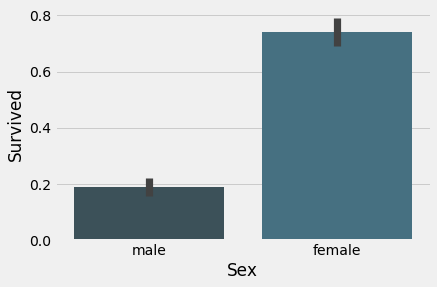

In [402]:
# barplot of survivavility vs. sex
s = sns.barplot(x="Sex", y="Survived", data=train)

print("Percentage of women that survived:", train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)[1]*100)
print("Percentage of men that survived:", train["Survived"][train["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

<div class="alert alert-info"> The method value_counts is an interesting one as it gives us the population of the different values in a column. In this case, we are accessing the column *Survived* of the train dataset for the female individuals. </div>

In [403]:
 train["Survived"][train["Sex"] == 'female'].value_counts(normalize = True)

1    0.742038
0    0.257962
Name: Survived, dtype: float64

<div class="alert alert-info"> This information could have also been extracted in a SQL like way. For SQL lovers, check this [link](https://pandas.pydata.org/pandas-docs/stable/comparison_with_sql.html). </div>

In [404]:
train.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

### Pclass

As we can see there is a huge bias in terms of survivavility when talking about sex, meaning that it will have a vital paper in the model. There is an obvious *Women and children first*.

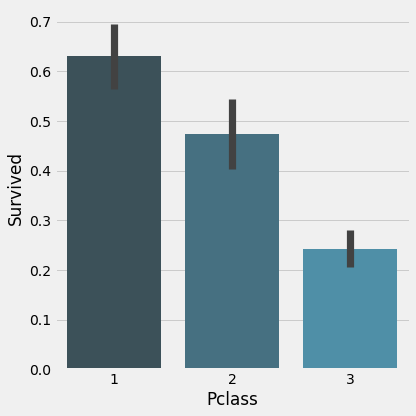

In [405]:
s = sns.factorplot(x="Pclass", y="Survived", data=train, kind='bar', size=6)

In [406]:
pd.crosstab(train['Pclass'], train['Survived'], margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


Some things had not changed: money makes things easier. Moreover, it is also important to check not only the variable impact on the target value, but also how this variable is distributed along the data. If only one passenger would had Pclass = 1 and he/she survived, the first class survival probability would have been a mind blowing 100%, but it would not be representative. Thanks to the crosstab method we do not just see that there are enough individuals present in each class, but also that the data is enough well sampled, meaning that we have at our disposal enough variability in the survival class to actually learn from it. If data would only show a small percentage of survivals, training a model that could actually predict survivavility would get pretty hard as there would not be enough information about the individuals who got to live.

Also, with only a small representation of the survived class (for example only a 5%), a constant model that always give '0' as an output would show an accuracy on 95% on the data! So please, always give a second and a third look to the data before making any conclusions.

### Embarked

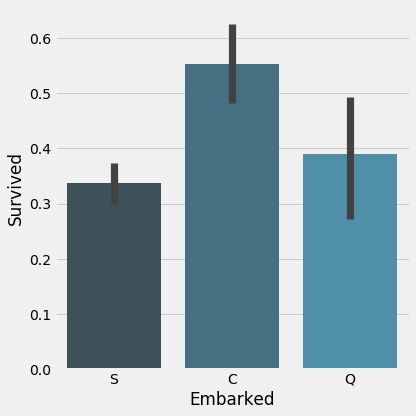

In [407]:
s = sns.factorplot(x="Embarked", y="Survived", data=train,
                   size=6, kind="bar")

In [408]:
pd.crosstab(train['Embarked'], train['Survived'], margins=True)

Survived,0,1,All
Embarked,,,
C,75,93,168
Q,47,30,77
S,427,217,644
All,549,340,889


Do the numbers ring any bells? We have a total of 168 passengers coming from Cherbourg, which shows the higher survivality rate, followed by the 77 passengers who embarked on Queenstown, with less survivavility and higher variance. If you now scroll up a bit, you can see that 216 passengers had a first class ticket, who also showed the top survivavility chances compared to the other ticket types. Could this two variables be related, meaning that the 216 first class passengers where more present in the 245 passengers embarking in Cherbourg and Queenstown?

What we were performing so far was a **univariate analysis**, where we only took into consideration one variable at a time. While this may be a good enough starting point we are losing information on the relation between features, so another type of analysis gains importance: **multivariate analysis**:

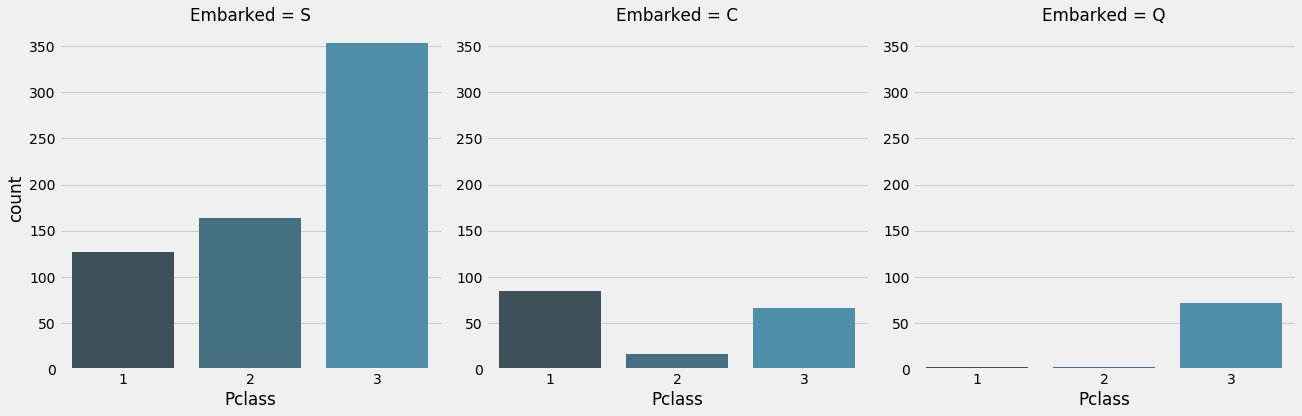

In [409]:
s = sns.factorplot("Pclass", col="Embarked", data=train,
                   size=6, kind="count")

Now it is farily easy to see that in S almost every 3rd class passenger embarked, whereas in C passengers are mostly from first class. However, this anulates our hypothesis of saying that first class passengers mainly emarked in C and Q.

We saw that women had a way higher survival rate. Just to be sure, let's check that the effect of the ticket class/embarkation port is no masked in the sex:

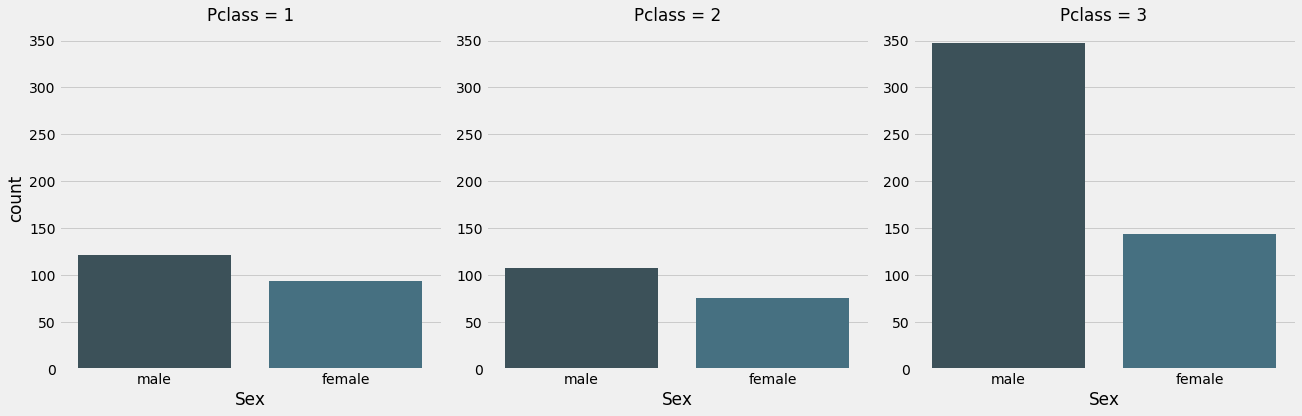

In [410]:
s = sns.factorplot("Sex", col="Pclass", data=train,
                   size=6, kind="count")

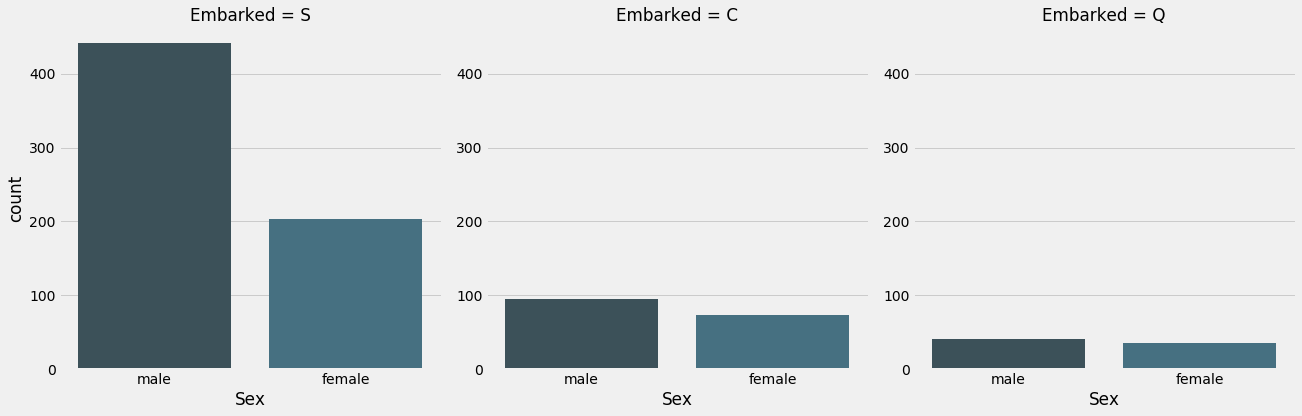

In [411]:
s = sns.factorplot("Sex", col="Embarked", data=train,
                   size=6, kind="count")

In [412]:
print('In Cabin we have %s different values.' % len(train['Cabin'].unique()))
print('In Ticket we have %s different values.' %len(train['Ticket'].unique()))

In Cabin we have 148 different values.
In Ticket we have 681 different values.


Both Cabin and Ticket have too much different classes, so we will not treat them as a *"normal"* categorical variable.

### Numerical Variables

A good thing about numerical variables is that we can plot a heatmap showing the correlation of all the variables against each other instead having to plot the probability one by one.

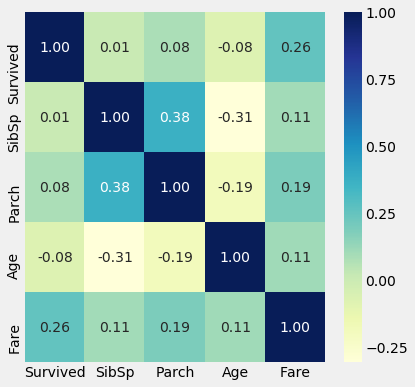

In [413]:
plt.figure(figsize=(6,6))
s = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(), annot=True, fmt = ".2f", cmap="YlGnBu")

Looking at the values of the first row/column (as we are mainly interested in the correlation with Survival), one can see that only Fare shows somehow a bit of correlation. Note that this does not mean that the rest of variables are no explanatory, but maybe we need to play a bit more with them first.

### Age

If we tried to run:
```python
sns.distplot(train['Age'])
```

an error would appear. This is the first encounter we would have with the infamous **missing values**. However, we will do a workaround by now and attack all missing values at the same time.

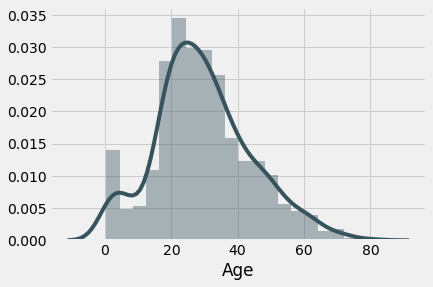

In [414]:
# Eliminate the nulls 
age = train['Age'][train['Age'].notnull()]
s = sns.distplot(age)

We can see that there is an odd peak of individuals with little age. Recall the note that age is fractional if less than 1. Let's check those individuals:

In [415]:
train.loc[train['Age']<5,'PassengerId'].count()

40

If we take a look at the babies abroad, we can see that all of them survived.

In [416]:
train.loc[train['Age']<1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


Check the age distributions of passengers that survived and those who did not:

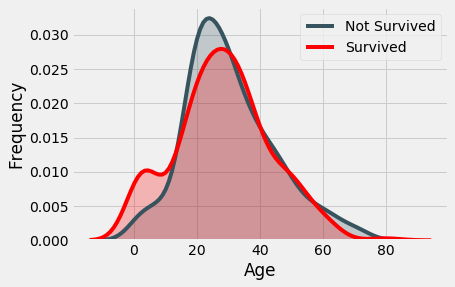

In [417]:
s = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], shade = True)
s = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax=s, color='red', shade= True)
s.set_xlabel("Age")
s.set_ylabel("Frequency")
s = s.legend(["Not Survived","Survived"])

We can clearly see how younger people got to survive and passengers with age between 60 - 80 have less chance to leave the boat.

### SibSp

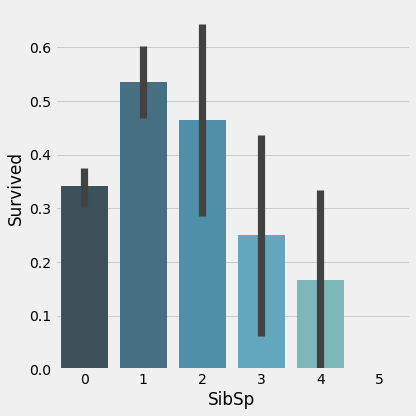

In [418]:
s = sns.factorplot(x="SibSp", y="Survived", data=train,
                   size=6, kind="bar", palette="GnBu_d")

Looks like both passengers without spouse or siblings and those who had a lot had less change to survive.

### Parch

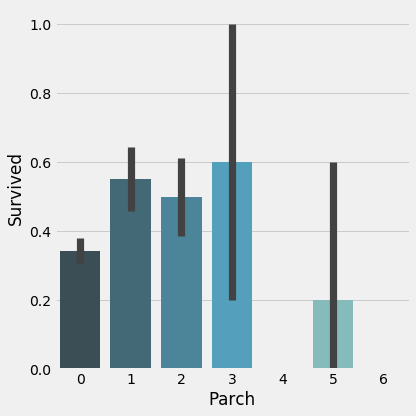

In [419]:
s = sns.factorplot(x="Parch", y="Survived", data=train,
                   size=6, kind="bar", palette="GnBu_d")

Again, small families have higher chance to survive, alhough there is a high variance for individuals with 3 parents and children.

### Fare

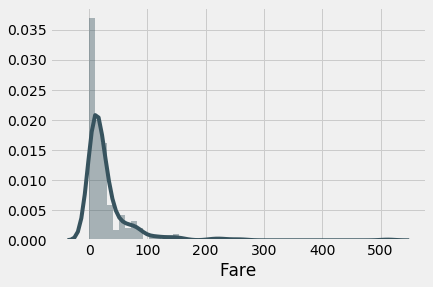

In [420]:
s = sns.distplot(train['Fare'])

The distribution shows a really high skewness (huge tail), so a logarithmic transformation helps in this case to normalize the values. We will make use of anonymous functions here, as we cannot convert those rows with Fare = 0, and from the plot we can see that there might be quite a few.

In [421]:
train["Fare"] = train["Fare"].map(lambda x: np.log(x) if x > 0 else 0)

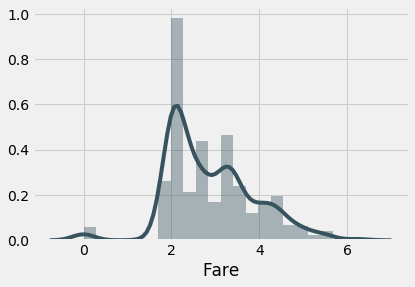

In [422]:
s = sns.distplot(train['Fare'])

The new distribution looks more beautiful. Remember to apply all the changes done to the train set to the test! However, null values appear again:

In [423]:
sum(test['Fare'].isnull())

1

As there is only one missing value, we can just input the mean of the column without any impact on the set.

In [424]:
test = test.fillna({'Fare' : test['Fare'].mean()}) 
test["Fare"] = test["Fare"].map(lambda x: np.log(x) if x > 0 else 0)

### Working with Missing Values

We have already seen that data will not always be informed, and the larger the dataset the higher number of values that we will have to study how to input. Luckily there is an interesting module **missingno** that helps us retrieve the information that we need:

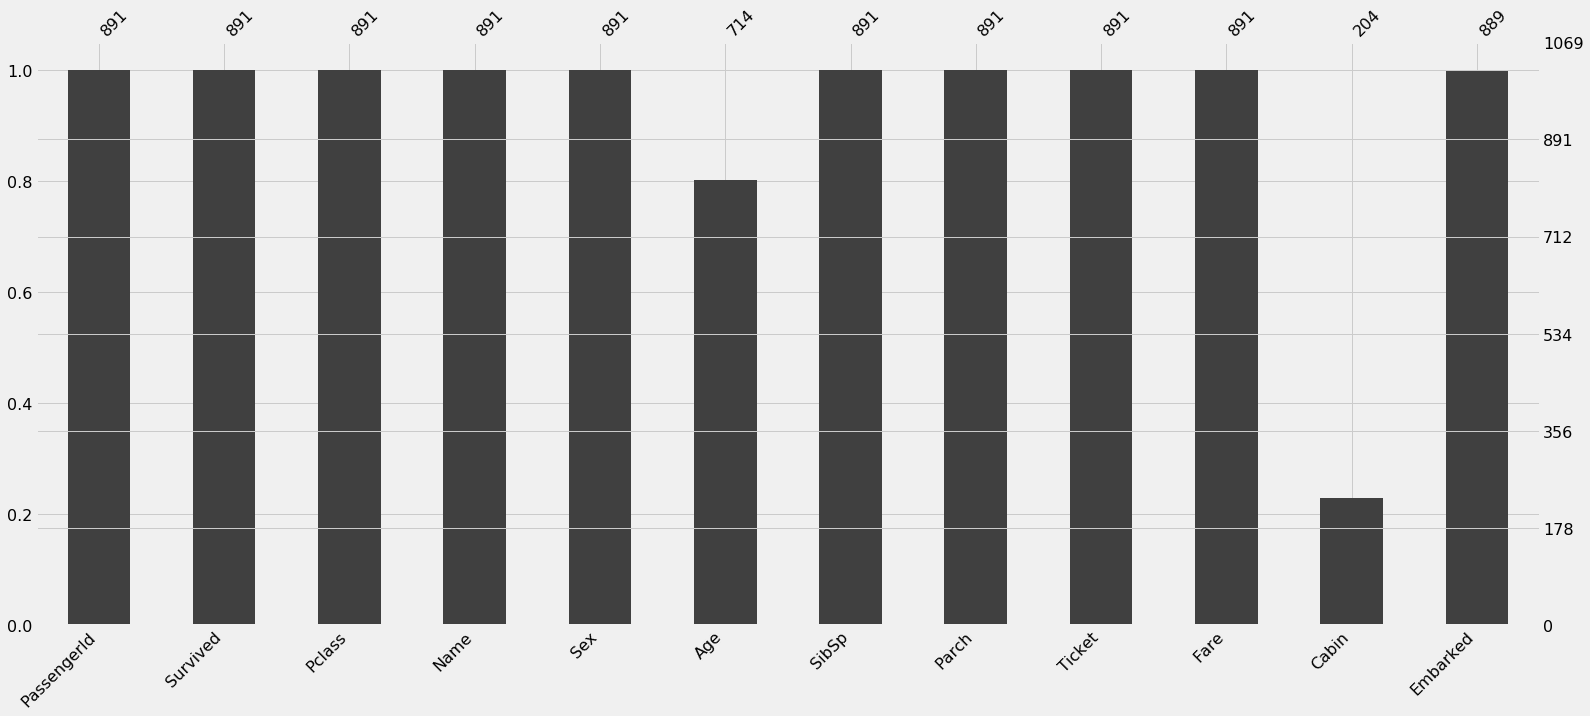

In [425]:
import missingno as msno

msno.bar(train)

This plot helps us visualize the percentage of data that is informed in each column. The main feature that will require our attention are Age and Cabin. Although it is a bit hard to see with this plot, Embarked has also 2 missing values. Another interesting plot provided by the module shows exactly the row where data is missing.

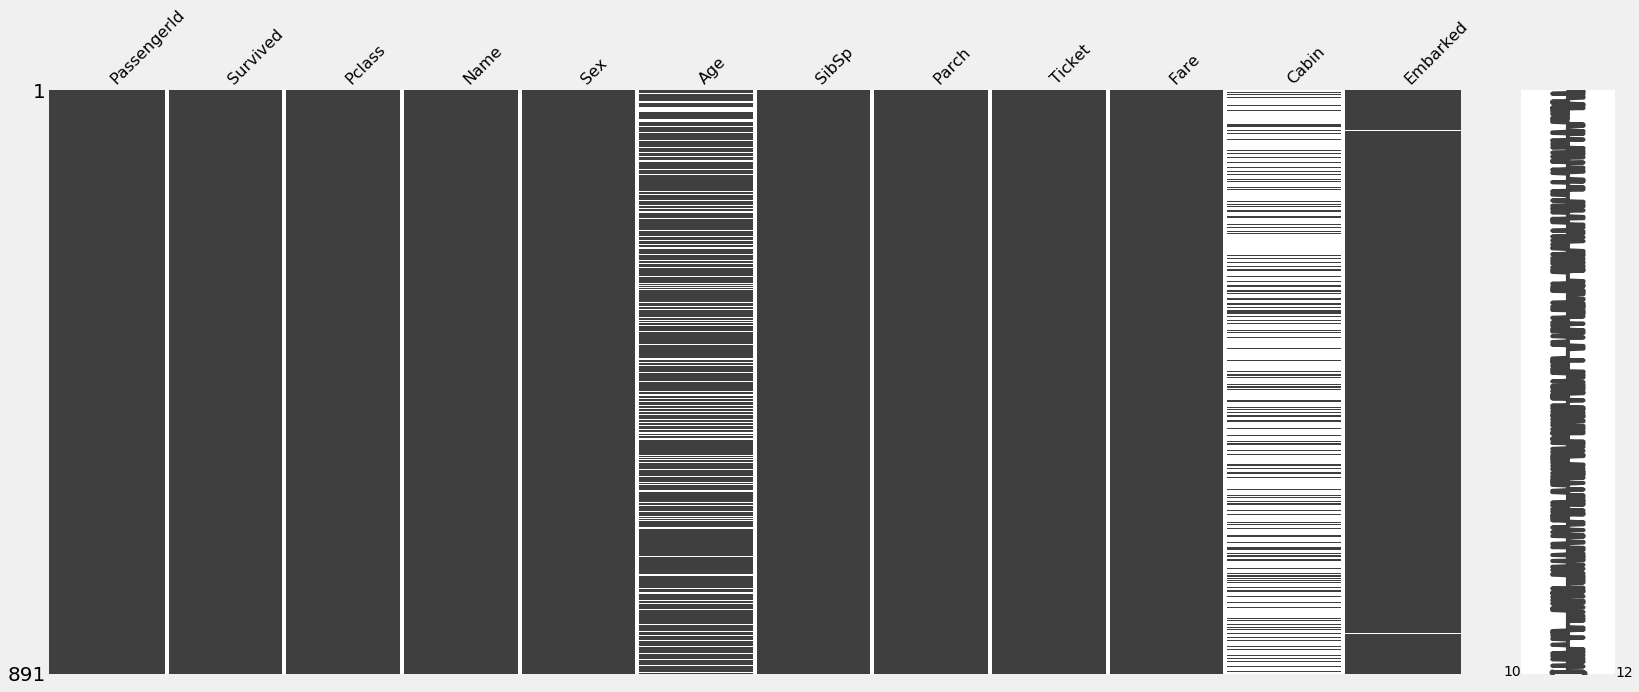

In [426]:
msno.matrix(train)

<div class="alert alert-info"> To obtain the raw numbers of missing values we can use the method isnull() from pandas: pd.isnull(train).sum() </div>

<div class="alert alert-info"> The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another: msno.heatmap(train) </div> (Not used here because of the lack of real variability in missing values).

Here we are presented with 3 different needed approaches to treat the null values:

- Age: Almost 80% of the data is present so we will try to input values the best we can.
- Embarked & Fare: When almost any value is missing, direct inputation solves the problem without distorting the rest of the data.
- Cabin: With roughly a 23% of data present, inputation is out of the scope.

We will start with the *easy* ones:

For the variable **Embarked**, as almost everyone came from Southampton we can directly put that.

In [427]:
train = train.fillna({'Embarked' : 'S'})

With a scenario like **Cabin**, the usual approach is to create a new dummy variable denoting if the cabin was informed or not for a given individual. In this case it makes sense as only a percentage of the passengers might have been wealthy enough to travel with a given private cabin. Note that any change in variables applied to the training set must also be applied to the test dataset.

In [428]:
train['CabinInf'] = train.Cabin.notnull().astype(int) 
test['CabinInf'] = test.Cabin.notnull().astype(int)

# we won't need the Cabin variable anymore:
train.drop(['Cabin'], axis=1, inplace=True)
test.drop(['Cabin'], axis=1, inplace=True)

It is a good practice to check if the new variables that we are creating are candidates of helping improve the model:

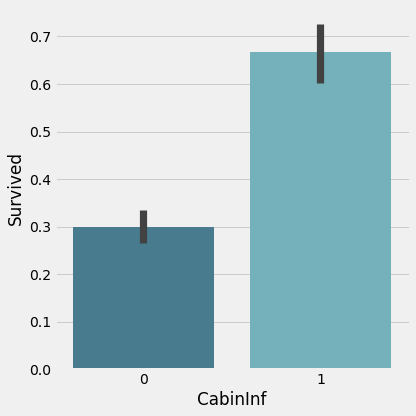

In [429]:
s = sns.factorplot(x="CabinInf", y="Survived", data=train,
                   size=6, kind="bar", palette="GnBu_d")

A naive technique that one could try to use to input **Age** is by applying the mean.

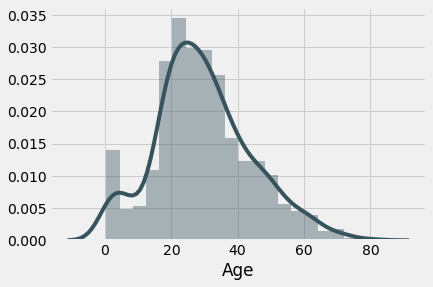

In [430]:
# Recall how the distribution looks like
s = sns.distplot(train.loc[train['Age'].notnull(),'Age'])

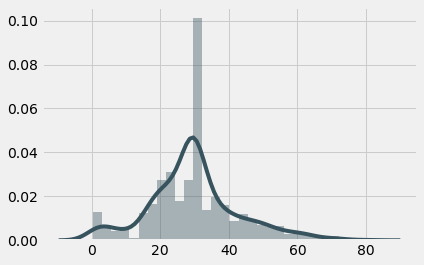

In [431]:
age = train['Age']
age = list(map(lambda x: age.mean() if np.isnan(x) else x, age))
s = sns.distplot(age)

Ok, there are quite a few things happening here. First we used the **map** python functionality, that lets us apply a function to each member of an input list. In this case we are interested in putting the mean of the variable age to the variables that where null. We could have also declared separatedly a function, however we made use of anonimous functions to achieve the same with just one line of code. 

Also, the important part here is that with this lazy approach the age distribution gets heavily distorted, so a deeper thought will be needed for this task.

## Feature Engineering

As we said maybe raw variables do not contain the most information or there are others from which we can extract different features. 

### Hidden Information: Title

We want our model to learn from the characteristics of the individuals, not the individuals themselves. This is why we will drop variables like PassengerId, Name and Ticket, as they are differentiative aspects of the individuals. However:

In [432]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object


See how each passenger has a different honorific. We can extract this information to learn about the social level of the individual.

In [433]:
for dataset in [train, test]:
    dataset['Title'] = dataset.Name.str.extract('([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


As we do not end up with too many categories another step will be perfomed putting together similar honorifics. We will classify in Master (young men, recall the sample of babies abroad we saw), Mr, Miss, Mrs and the Elite, combining all the honorifics of the novelty and rich.

In [434]:
train['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
     ['Miss','Miss','Miss','Elite','Elite','Elite','Elite','Elite','Elite','Elite','Elite','Elite','Elite'],inplace=True)
test['Title'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don','Dona'],
    ['Miss','Miss','Miss','Elite','Elite','Elite','Elite','Elite','Elite','Elite','Elite','Elite','Elite','Elite'],inplace=True)

Now we can use this new variable to input the age with lesser error, as we are working in a closer range of values. For each Title we will compute the mean and standard deviation of the age of the individuals, and instead of putting the same age to rows with missing values, a random normal value will be used to mantain the distribution.

In [435]:
titles = ['Mr','Miss','Mrs','Master','Elite']
for dataset in [train, test]:
    for title in titles:
        mean = dataset.loc[dataset['Title'] == title,'Age'].mean()
        std = dataset.loc[dataset['Title'] == title,'Age'].std()
        dataset.loc[dataset['Title'] == title,'Age'] = list(map(lambda x: np.random.normal(loc=mean, scale=std) 
                                  if np.isnan(x) else x, dataset.loc[dataset['Title'] == title,'Age']))

Look how using information from another variables and inputing a random value within a calculated range preserves the distribution.

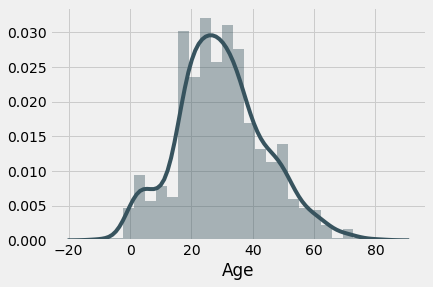

In [436]:
s = sns.distplot(train['Age'])

Which is the impact of this new feature in the survivavility:

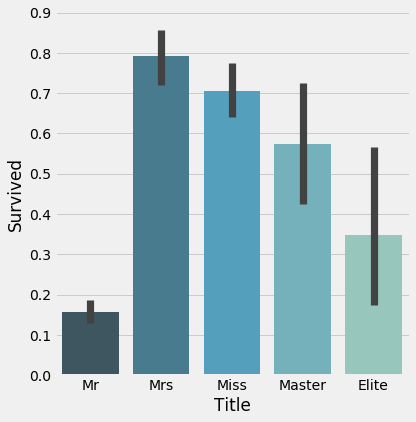

In [437]:
s = sns.factorplot(x="Title", y="Survived", data=train,
                   size=6, kind="bar", palette="GnBu_d")

We indeed see significative differences among the classes.

### Combining Variables: Family

Both SibSp and Parch give different parts of the same information: does a passenger travel alone or with company? How many family members are with him? Thus, we will join this information together and try to differentiate meaningful classes.

In [438]:
for dataset in [train, test]:
    dataset['Family'] = dataset['SibSp'] + dataset['Parch']

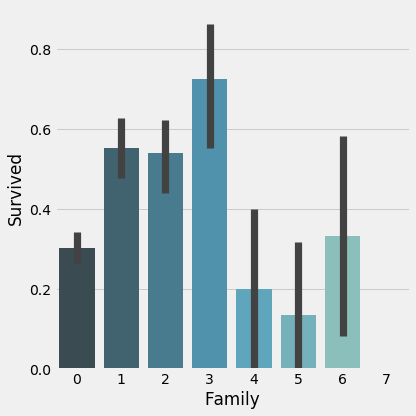

In [439]:
s = sns.factorplot(x="Family", y="Survived", data=train,
                   size=6, kind="bar", palette="GnBu_d")

Let's create dummy variables for each category that shows difference enough in survivavility: Being alone, 1 to 3 family members, 4 to 5 or 6 members abroad.

In [440]:
for dataset in [train, test]:
    dataset['Alone'] = dataset['Family'].map(lambda i: 1 if i == 0 else 0)
    dataset['SmallF'] = dataset['Family'].map(lambda i: 1 if 1 <= i < 4 else 0)
    dataset['MedF'] = dataset['Family'].map(lambda i: 1 if 4 <= i < 6 else 0)
    dataset['LargeF'] = dataset['Family'].map(lambda i: 1 if i >= 6 else 0)

### Ticket

In [441]:
train['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

Observe how we have mainly two types of tickets: containing letters and not. Lettered ones may refer also to the cabin or any special place to stay of the boat. We therefore create a new variable exploiting this difference, as otherwise Ticket is just a identificative variable that needs to be dropped.

In [442]:
train['TicketInf'] = train['Ticket'].map(lambda i: 1 if re.match('[a-zA-Z]', i) else 0)

Check if our assumption was right and it makes sense to use this variable:

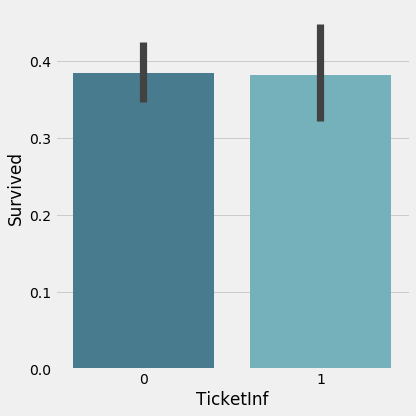

In [443]:
s = sns.factorplot(x="TicketInf", y="Survived", data=train,
                   size=6, kind="bar", palette="GnBu_d")

There is no real difference in survivavility rates so we are better dropping it.

In [444]:
train.drop(['TicketInf'], axis=1, inplace=True)

### Age and Fare bins

We will not work with just raw values here but group them in intervals. Function pd.qcut works by using the quantiles of the data, so we group train and test to obtain the same bins. Note that we need to do this as the example is for a kaggle competition, but in real life there is not a test dataset.

In [445]:
ids_train = train.shape[0]
data = pd.concat([train, test], axis=0)

data['BinFare'] = pd.qcut(data['Fare'], 5)
data['BinAge'] = pd.qcut(data['Age'], 4)

le = LabelEncoder()
data['BinFareCode'] = le.fit_transform(data['BinFare'])
data['BinAgeCode'] = le.fit_transform(data['BinAge'])

train['BinFareCode'] = data['BinFareCode'][:ids_train]
test['BinFareCode'] = data['BinFareCode'][ids_train:]

train['BinAgeCode'] = data['BinAgeCode'][:ids_train]
test['BinAgeCode'] = data['BinAgeCode'][ids_train:]

train.drop(['Fare','Age'], axis=1, inplace=True)
test.drop(['Fare','Age'], axis=1, inplace=True)

Finally map sex into 0,1:

In [446]:
train['Sex'].replace(['male','female'],[0,1],inplace=True)
test['Sex'].replace(['male','female'],[0,1],inplace=True)

Encode the last variables:

In [447]:
for feature in ['Embarked','Title']:
    train[feature] = le.fit_transform(train[feature])
    test[feature] = le.transform(test[feature])

Now we are almost good to go. We just need to drop the identificators and *old variables* and create dummy variables.

In [448]:
train.drop(['PassengerId','Name','Ticket','SibSp','Parch','Family'], axis=1, inplace=True)
test.drop(['PassengerId','Name','Ticket','SibSp','Parch','Family'], axis=1, inplace=True)

In [449]:
train.head()

,Survived,Pclass,Sex,Embarked,CabinInf,Title,Alone,SmallF,MedF,LargeF,BinFareCode,BinAgeCode
0,0,3,0,2,0,3,0,1,0,0,0,1
1,1,1,1,0,1,4,0,1,0,0,4,2
2,1,3,1,2,0,2,1,0,0,0,1,1
3,1,1,1,2,1,4,0,1,0,0,4,2
4,0,3,0,2,0,3,1,0,0,0,1,2


## Modelling

Ok, what happened so far?

- Loaded and visualized data trying to get an idea of relation between explanatory variables and the response variable or target.
- Created new features trying to exploit hidden data and increase the effect on the target.
- Encoded categorical variables.
- Dropped useless information.

We are now left with a numerical matrix of data. Training dataset will get splitted into a train set which will correspond to the data used to fit the model and a validation set to assess performance. Then, the best parameters for the model will be looked for using the GridSearch technique, which iterates over all possible combinations and outputs the best one.


In [450]:
y_train=train['Survived']
X_train=train.drop('Survived', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=13)

We don't want to run that expensive GS again:

![XGBoost GridSearchCV](GSCVxgboost.png)

Accuracy: 80.32% (9.24%)


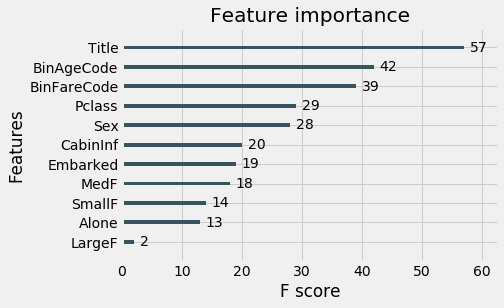

In [451]:
model = xgb.XGBClassifier(booster='gbtree', silent=1, seed=0, base_score=0.5, subsample=0.75)
grid ={'max_delta_step': 0, 
       'max_depth': 10, 
       'min_child_weight': 1, 
       'n_estimators': 240, 
       'colsample_bytree': 0.55, 
       'gamma': 3,
       'learning_rate': 0.1}
model.set_params(**grid)
model.fit(X_train,y_train)
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(model, np.array(X_val), np.array(y_val), cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
plot_importance(model)
plt.show()

In [452]:
X_train=train.drop('Survived', axis=1)
y_train=train['Survived']
model.fit(X_train, y_train)
y_pred = model.predict(test)

In [453]:
result = pd.DataFrame({'PassengerId': test_id,'Survived': y_pred}, columns=['PassengerId','Survived'])
result.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [454]:
result.to_csv('../output/sub2_xgb.csv', sep=",", index=False)

Let's compare it with LightGBM:

In [455]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary', 
          'nthread': 5, # Updated from nthread
          'num_leaves': 64, 
          'learning_rate': 0.05, 
          'max_bin': 512, 
          'subsample_for_bin': 200,
          'subsample': 1, 
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 5, 
          'reg_lambda': 10,
          'min_split_gain': 0.5, 
          'min_child_weight': 1, 
          'min_child_samples': 5, 
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    'learning_rate': [0.005,0.1],
    'n_estimators': [8,16,24,64,128],
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], # Updated from 'seed'
    'colsample_bytree' : [0.64, 0.65, 0.66],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }

# Create classifier to use. Note that parameters have to be input manually
# not as a dict!
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt', 
          objective = 'binary', 
          n_jobs = 5, # Updated from 'nthread' 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'], 
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'], 
          subsample_freq = params['subsample_freq'], 
          min_split_gain = params['min_split_gain'], 
          min_child_weight = params['min_child_weight'], 
          min_child_samples = params['min_child_samples'], 
          scale_pos_weight = params['scale_pos_weight'])

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)

I installed lightGBM for computing with GPU, check how incredibly faster the computations are:

In [456]:
grid.fit(X_train, y_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

Fitting 4 folds for each of 1440 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 790 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2290 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 4264 tasks      | elapsed:   37.6s


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.1, 'n_estimators': 64, 'num_leaves': 12, 'objective': 'binary', 'random_state': 501, 'reg_alpha': 1, 'reg_lambda': 1.2, 'subsample': 0.75}
0.8249158249158249


[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:   51.2s finished


In [461]:
params = {'boosting_type': 'gbdt', 
          'colsample_bytree': 0.64, 
          'learning_rate': 0.1, 
          'n_estimators': 64, 
          'num_leaves': 8, 
          'objective': 'binary', 
          'random_state': 501, 
          'reg_alpha': 1, 
          'reg_lambda': 1.2, 
          'subsample': 0.75}

Accuracy: 78.29% (8.76%)


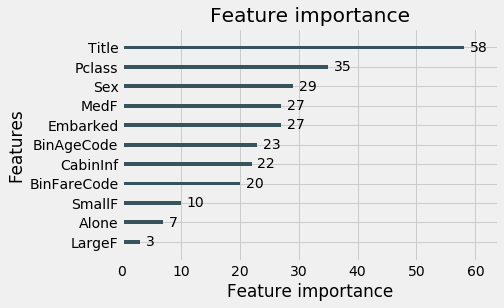

In [462]:
mdl.set_params(**params)
mdl.fit(X_train,y_train)
kfold = KFold(n_splits=10, random_state=7)
results = cross_val_score(mdl, np.array(X_val), np.array(y_val), cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
lgb.plot_importance(mdl)
plt.show()

In [463]:
mdl.fit(X_train, y_train)
y_pred = mdl.predict(test)

result = pd.DataFrame({'PassengerId': test_id,'Survived': y_pred}, columns=['PassengerId','Survived'])
result.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [464]:
result.to_csv('../output/sub3_lgb.csv', sep=",", index=False)